In [2]:
import sqlite3
import pandas as pd

In [9]:
conn = sqlite3.connect('nyc_arrest_data.db')
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

for table in tables:
    cursor.execute(f'DROP TABLE IF EXISTS {table[0]}')

conn.commit()
conn.close()

In [10]:
conn = sqlite3.connect('nyc_arrest_data.db')
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

In [11]:
df = pd.read_csv(r'C:\Users\deenr\OneDrive\Desktop\Work in Progress\nyc_arrest_data\src\NYPD_Arrests_Data__Historic__20240906.csv')

def find_city(code):
    codes = {'B': 'Bronx', 'S': 'Staten Island', 'K': 'Brooklyn', 'M': 'Manhattan' , 'Q': 'Queens'}
    if pd.isna(code):
        return 'Unknown'
    return codes.get(code, 'Unknown')

def find_felony(felony):
    felonies = {'F': 'Felony','M': 'Misdemeanor', 'V': 'Violation', 'I': 'Other'}
    if felony in felonies:
        return felonies[felony]
    else:
        return 'Other'

date = df['ARREST_DATE'].str.split("/", n=3, expand=True)
df['year'] = date[2].astype('int32')
df['month'] = date[0].astype('int32')

df['ARREST_BORO'] = df['ARREST_BORO'].apply(find_city)
df['LAW_CAT_CD'] = df['LAW_CAT_CD'].apply(find_felony)

df = df.drop(['ARREST_KEY', 'PD_CD', 'PD_DESC', 'KY_CD', 'LAW_CODE', 'JURISDICTION_CODE', 'X_COORD_CD', 'Y_COORD_CD'], axis=1)

df.head()



,ARREST_DATE,OFNS_DESC,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,AGE_GROUP,PERP_SEX,PERP_RACE,Latitude,Longitude,Lon_Lat,year,month
0,08/07/2018,NaN,Felony,Brooklyn,73,45-64,M,BLACK,40.671110,-73.915881,POINT (-73.91588130999997 40.67110980800004),2018,8
1,11/13/2020,ROBBERY,Felony,Bronx,40,25-44,M,BLACK,40.810398,-73.924895,POINT (-73.92489531099994 40.810398494000026),2020,11
2,07/01/2019,NaN,Felony,Manhattan,23,25-44,M,BLACK HISPANIC,40.789348,-73.947352,POINT (-73.94735241299998 40.78934789300007),2019,7
3,02/22/2020,DANGEROUS DRUGS,Misdemeanor,Manhattan,32,25-44,M,BLACK,40.829163,-73.937272,POINT (-73.93727189399993 40.829163304000076),2020,2
4,11/10/2020,ASSAULT 3 & RELATED OFFENSES,Misdemeanor,Bronx,49,25-44,M,WHITE,40.854826,-73.854880,POINT (-73.85487970999998 40.85482622300003),2020,11


In [12]:
df.isnull().sum()

ARREST_DATE           0
OFNS_DESC          9169
LAW_CAT_CD            0
ARREST_BORO           0
ARREST_PRECINCT       0
AGE_GROUP            17
PERP_SEX              0
PERP_RACE             0
Latitude              1
Longitude             1
Lon_Lat               1
year                  0
month                 0
dtype: int64

In [13]:
df['OFNS_DESC'] = df['OFNS_DESC'].fillna('Unknown')

In [14]:
df = df.dropna()
df.isnull().sum()

ARREST_DATE        0
OFNS_DESC          0
LAW_CAT_CD         0
ARREST_BORO        0
ARREST_PRECINCT    0
AGE_GROUP          0
PERP_SEX           0
PERP_RACE          0
Latitude           0
Longitude          0
Lon_Lat            0
year               0
month              0
dtype: int64

In [22]:
valid_age_groups = ['25-44', '18-24', '45-64', '<18', '65+']
filtered_df = df[df['AGE_GROUP'].isin(valid_age_groups)]
df = filtered_df


In [23]:
df['LAW_CAT_CD'].unique()

array(['Felony', 'Misdemeanor', 'Violation', 'Other'], dtype=object)

In [29]:
df.isnull().sum()

ARREST_DATE        0
OFNS_DESC          0
LAW_CAT_CD         0
ARREST_BORO        0
ARREST_PRECINCT    0
AGE_GROUP          0
PERP_SEX           0
PERP_RACE          0
Latitude           0
Longitude          0
Lon_Lat            0
year               0
month              0
dtype: int64

In [30]:
df.to_sql('arrest', conn, if_exists='replace', index='False')

5725326

In [31]:
# ofns_desc time series analysis

query = """ 
SELECT OFNS_DESC, YEAR, COUNT(*) as COUNT
FROM arrest
GROUP BY OFNS_DESC, YEAR
ORDER BY YEAR ASC;
"""
df = pd.read_sql_query(query, conn)

df

,OFNS_DESC,year,COUNT
0,ADMINISTRATIVE CODE,2006,72
1,ALCOHOLIC BEVERAGE CONTROL LAW,2006,284
2,ANTICIPATORY OFFENSES,2006,77
3,ARSON,2006,151
4,ASSAULT 3 & RELATED OFFENSES,2006,31712
...,...,...,...
1173,THEFT OF SERVICES,2023,154
1174,THEFT-FRAUD,2023,186
1175,UNAUTHORIZED USE OF A VEHICLE,2023,630
1176,UNLAWFUL POSS. WEAP. ON SCHOOL,2023,1


In [32]:
df['OFNS_DESC'].unique().tolist()

['ADMINISTRATIVE CODE',
 'ALCOHOLIC BEVERAGE CONTROL LAW',
 'ANTICIPATORY OFFENSES',
 'ARSON',
 'ASSAULT 3 & RELATED OFFENSES',
 "BURGLAR'S TOOLS",
 'BURGLARY',
 'CHILD ABANDONMENT/NON SUPPORT 1',
 'CRIMINAL MISCHIEF & RELATED OFFENSES',
 'CRIMINAL TRESPASS',
 'DANGEROUS DRUGS',
 'DANGEROUS WEAPONS',
 'DISORDERLY CONDUCT',
 'DISRUPTION OF A RELIGIOUS SERVICE',
 'ESCAPE 3',
 'F.C.A. P.I.N.O.S.',
 'FELONY ASSAULT',
 'FORCIBLE TOUCHING',
 'FORGERY',
 'FRAUDS',
 'FRAUDULENT ACCOSTING',
 'GAMBLING',
 'GRAND LARCENY',
 'GRAND LARCENY OF MOTOR VEHICLE',
 'HARASSMENT',
 'HARRASSMENT 2',
 'HOMICIDE-NEGLIGENT,UNCLASSIFIED',
 'HOMICIDE-NEGLIGENT-VEHICLE',
 'INTOXICATED & IMPAIRED DRIVING',
 'INTOXICATED/IMPAIRED DRIVING',
 'JOSTLING',
 'KIDNAPPING & RELATED OFFENSES',
 'LOITERING',
 'LOITERING FOR DRUG PURPOSES',
 'LOITERING/GAMBLING (CARDS, DICE, ETC)',
 'MISCELLANEOUS PENAL LAW',
 'MOVING INFRACTIONS',
 'MURDER & NON-NEGL. MANSLAUGHTER',
 'OFF. AGNST PUB ORD SENSBLTY & RGHTS TO PRIV',
 'OFFENSE

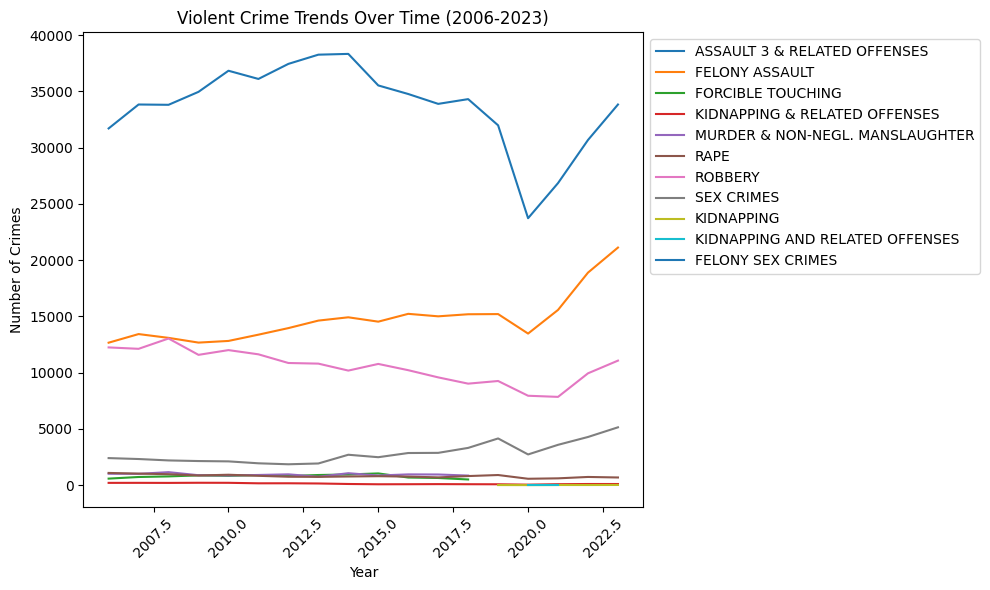

In [33]:
import matplotlib.pyplot as plt

query = """ 
SELECT OFNS_DESC, YEAR, COUNT(*) as COUNT
FROM arrest
WHERE OFNS_DESC IN (
    'MURDER & NON-NEGL. MANSLAUGHTER',
    'FELONY ASSAULT',
    'ASSAULT 3 & RELATED OFFENSES',
    'RAPE',
    'SEX CRIMES',
    'FELONY SEX CRIMES',
    'ROBBERY',
    'KIDNAPPING & RELATED OFFENSES',
    'KIDNAPPING',
    'KIDNAPPING AND RELATED OFFENSES',
    'FORCIBLE TOUCHING'
)
GROUP BY OFNS_DESC, YEAR
ORDER BY YEAR ASC;
"""

violent_crimes = pd.read_sql_query(query, conn)
violent_crimes['year'] = violent_crimes['year'].astype(int)

min_year = violent_crimes['year'].min()
max_year = violent_crimes['year'].max()
years = pd.DataFrame({'year': range(min_year, max_year + 1)})

ls = violent_crimes['OFNS_DESC'].unique().tolist()
plt.figure(figsize=(10, 6))  # Ensure the plot is large enough

for i in ls:
    data = violent_crimes[violent_crimes['OFNS_DESC'] == i]
    full = pd.merge(years, data, on='year', how='left')
    full['COUNT'].fillna(0)
    plt.plot(full['year'], full['COUNT'], label=i)

plt.title(f'Violent Crime Trends Over Time ({min_year}-{max_year})')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


<Axes: xlabel='OFNS_DESC', ylabel='OFNS_DESC'>

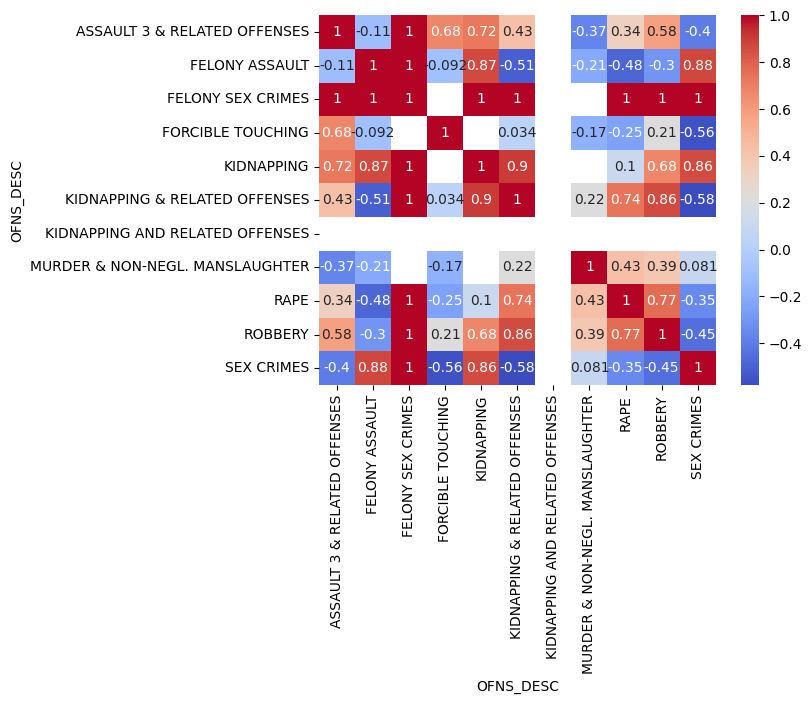

In [34]:
pivoted_df = violent_crimes.pivot(index='year', columns='OFNS_DESC', values='COUNT')
corr_matrix = pivoted_df.corr()

# Plot heatmap using seaborn
import seaborn as sns
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

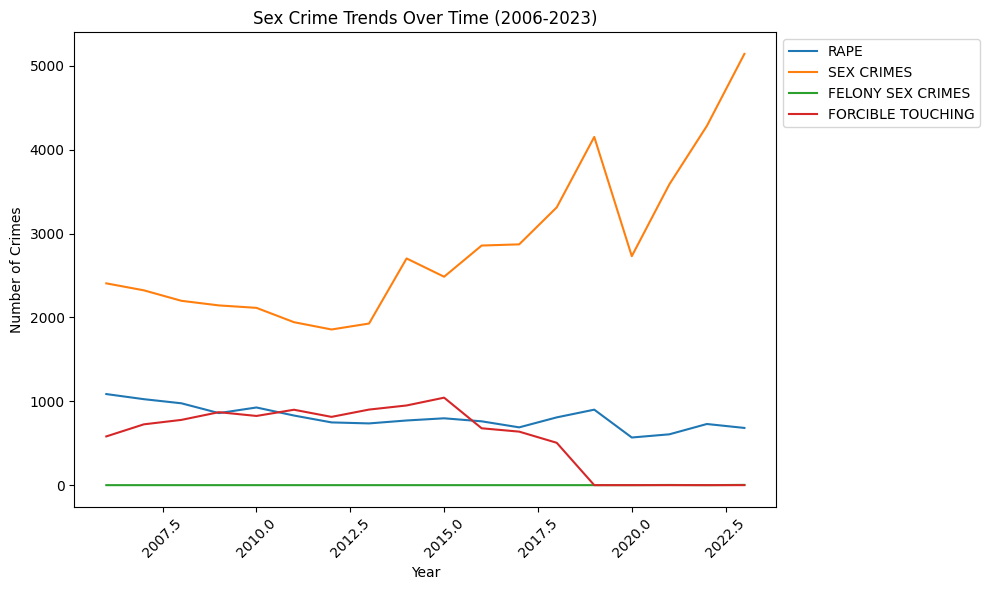

In [35]:
# now more specificity
ls = ['RAPE',
    'SEX CRIMES',
    'FELONY SEX CRIMES',
    'FORCIBLE TOUCHING']

plt.figure(figsize=(10,6))

for i, j in enumerate(ls):
    data = violent_crimes[violent_crimes['OFNS_DESC'] == j]
    full = pd.merge(years, data, on='year', how='left')
    full['COUNT'] = full['COUNT'].fillna(0)
    plt.plot(full['year'], full['COUNT'], label=j)

plt.title(f'Sex Crime Trends Over Time ({min_year}-{max_year})')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()



In [36]:
conn = sqlite3.connect('nyc_arrest_data.db')

query = """ 
SELECT LONGITUDE, LATITUDE, ARREST_DATE
FROM arrest
WHERE OFNS_DESC IN (
    'RAPE',
    'SEX CRIMES',
    'FELONY SEX CRIMES',
    'FORCIBLE TOUCHING'
)
"""

sex_crime_data = pd.read_sql_query(query, conn)

sex_crime_data['ARREST_DATE'] = pd.to_datetime(sex_crime_data['ARREST_DATE'])

In [37]:
sex_crime_data

,Longitude,Latitude,ARREST_DATE
0,-74.005407,40.734226,2020-12-12
1,-74.077483,40.644726,2020-12-09
2,-73.997491,40.716196,2020-10-02
3,-73.945420,40.815732,2020-10-20
4,-73.767843,40.760185,2020-10-17
...,...,...,...
75735,-73.840072,40.682398,2023-12-22
75736,-73.881811,40.671360,2023-12-16
75737,-73.851542,40.722641,2023-12-27
75738,-73.827126,40.830722,2023-12-09


In [38]:
import folium
from folium.plugins import HeatMapWithTime


sex_crime_data['YEAR'] = sex_crime_data['ARREST_DATE'].dt.year

grouped = sex_crime_data.groupby('YEAR')[['Latitude', 'Longitude']].apply(lambda x: x.values.tolist()).tolist()

nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

HeatMapWithTime(grouped, radius=10).add_to(nyc_map)

nyc_map.save('nyc_sex_crime_heatmap.html')

nyc_map

In [39]:
cursor = conn.cursor()

cursor.execute("PRAGMA table_info(arrest)")

for i in cursor.fetchall(): print(i)

(0, 'False', 'INTEGER', 0, None, 0)
(1, 'ARREST_DATE', 'TEXT', 0, None, 0)
(2, 'OFNS_DESC', 'TEXT', 0, None, 0)
(3, 'LAW_CAT_CD', 'TEXT', 0, None, 0)
(4, 'ARREST_BORO', 'TEXT', 0, None, 0)
(5, 'ARREST_PRECINCT', 'INTEGER', 0, None, 0)
(6, 'AGE_GROUP', 'TEXT', 0, None, 0)
(7, 'PERP_SEX', 'TEXT', 0, None, 0)
(8, 'PERP_RACE', 'TEXT', 0, None, 0)
(9, 'Latitude', 'REAL', 0, None, 0)
(10, 'Longitude', 'REAL', 0, None, 0)
(11, 'Lon_Lat', 'TEXT', 0, None, 0)
(12, 'year', 'INTEGER', 0, None, 0)
(13, 'month', 'INTEGER', 0, None, 0)


In [40]:
query = """ 
SELECT PERP_RACE, YEAR, OFNS_DESC
FROM arrest
WHERE OFNS_DESC IN (
    'RAPE',
    'SEX CRIMES',
    'FELONY SEX CRIMES',
    'FORCIBLE TOUCHING'
)
ORDER BY YEAR ASC;
"""

sex_crime_by_race = pd.read_sql_query(query, conn)

sex_crime_by_race['OFNS_DESC'] = 'SEX CRIME'

In [41]:
sex_crime_by_race

,PERP_RACE,year,OFNS_DESC
0,BLACK,2006,SEX CRIME
1,BLACK,2006,SEX CRIME
2,BLACK HISPANIC,2006,SEX CRIME
3,BLACK,2006,SEX CRIME
4,BLACK,2006,SEX CRIME
...,...,...,...
75735,BLACK,2023,SEX CRIME
75736,WHITE HISPANIC,2023,SEX CRIME
75737,BLACK,2023,SEX CRIME
75738,ASIAN / PACIFIC ISLANDER,2023,SEX CRIME


In [42]:
grouped_data = sex_crime_by_race.groupby(['PERP_RACE', 'year']).size().reset_index(name='COUNT')
grouped_data = grouped_data.pivot(index='year', columns='PERP_RACE', values='COUNT').fillna(0)
grouped_data

PERP_RACE,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,OTHER,UNKNOWN,WHITE,WHITE HISPANIC
year,,,,,,,,
2006,16.0,185.0,1710.0,330.0,21.0,58.0,419.0,1334.0
2007,6.0,195.0,1659.0,368.0,0.0,47.0,421.0,1377.0
2008,14.0,218.0,1548.0,334.0,0.0,50.0,393.0,1395.0
2009,23.0,174.0,1624.0,357.0,0.0,50.0,403.0,1241.0
2010,9.0,205.0,1620.0,350.0,0.0,43.0,401.0,1237.0
2011,11.0,194.0,1491.0,340.0,0.0,53.0,406.0,1177.0
2012,9.0,168.0,1441.0,270.0,0.0,53.0,378.0,1099.0
2013,11.0,200.0,1418.0,363.0,0.0,80.0,356.0,1136.0
2014,13.0,282.0,1845.0,414.0,0.0,70.0,434.0,1366.0


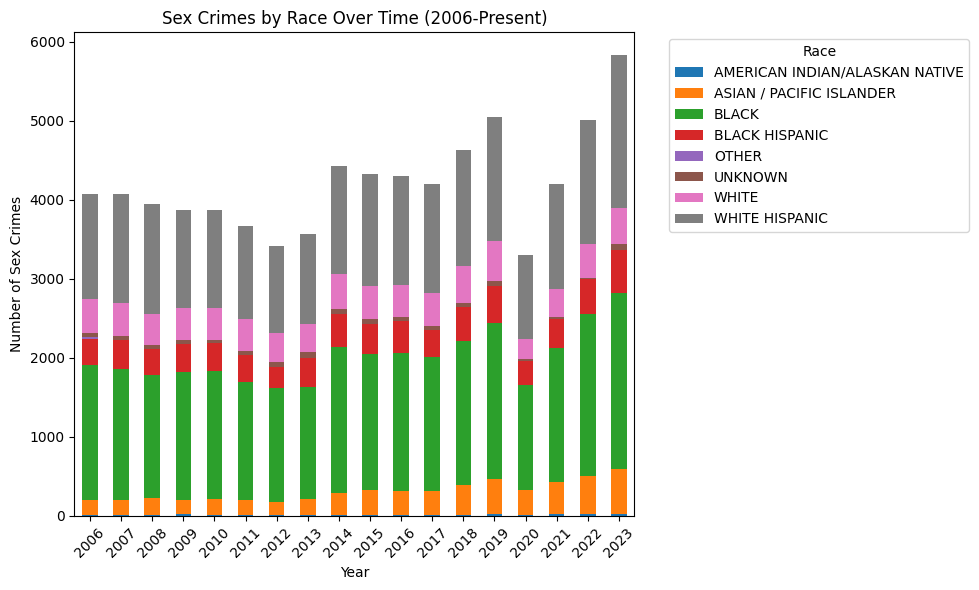

In [43]:
import matplotlib.pyplot as plt

grouped_data.plot(kind='bar', stacked=True, figsize=(10,6))

plt.title('Sex Crimes by Race Over Time (2006-Present)')
plt.xlabel('Year')
plt.ylabel('Number of Sex Crimes')
plt.xticks(rotation=45)
plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [44]:
query = """ 
SELECT OFNS_DESC, YEAR, AGE_GROUP, PERP_RACE
FROM arrest
WHERE OFNS_DESC IS 'CANNABIS RELATED OFFENSES'
ORDER BY YEAR ASC;
"""

abortion_crime = pd.read_sql_query(query, conn)


abortion_crime

,OFNS_DESC,year,AGE_GROUP,PERP_RACE
0,CANNABIS RELATED OFFENSES,2022,25-44,BLACK
1,CANNABIS RELATED OFFENSES,2022,25-44,BLACK
2,CANNABIS RELATED OFFENSES,2022,18-24,WHITE HISPANIC
3,CANNABIS RELATED OFFENSES,2022,25-44,WHITE
4,CANNABIS RELATED OFFENSES,2022,25-44,BLACK
...,...,...,...,...
565,CANNABIS RELATED OFFENSES,2023,25-44,WHITE HISPANIC
566,CANNABIS RELATED OFFENSES,2023,25-44,BLACK HISPANIC
567,CANNABIS RELATED OFFENSES,2023,25-44,BLACK HISPANIC
568,CANNABIS RELATED OFFENSES,2023,18-24,ASIAN / PACIFIC ISLANDER


In [54]:
conn = sqlite3.connect('nyc_arrest_data.db')
query = """ 
SELECT OFNS_DESC, ARREST_BORO, PERP_SEX, PERP_RACE, AGE_GROUP
FROM arrest
"""

temp = pd.read_sql_query(query, conn)

temp = temp.sample(n=130000, random_state=42)

temp

,OFNS_DESC,ARREST_BORO,PERP_SEX,PERP_RACE,AGE_GROUP
195933,DANGEROUS DRUGS,Manhattan,M,BLACK,45-64
2031653,OTHER STATE LAWS,Brooklyn,M,BLACK,25-44
913979,DANGEROUS DRUGS,Bronx,M,BLACK,18-24
1884796,DANGEROUS DRUGS,Queens,M,WHITE HISPANIC,18-24
3337666,DANGEROUS WEAPONS,Brooklyn,M,BLACK,<18
...,...,...,...,...,...
425015,ROBBERY,Bronx,M,UNKNOWN,<18
1433891,MISCELLANEOUS PENAL LAW,Bronx,M,BLACK,25-44
3013986,ASSAULT 3 & RELATED OFFENSES,Bronx,M,WHITE HISPANIC,18-24
709158,OTHER OFFENSES RELATED TO THEFT,Manhattan,M,WHITE HISPANIC,45-64


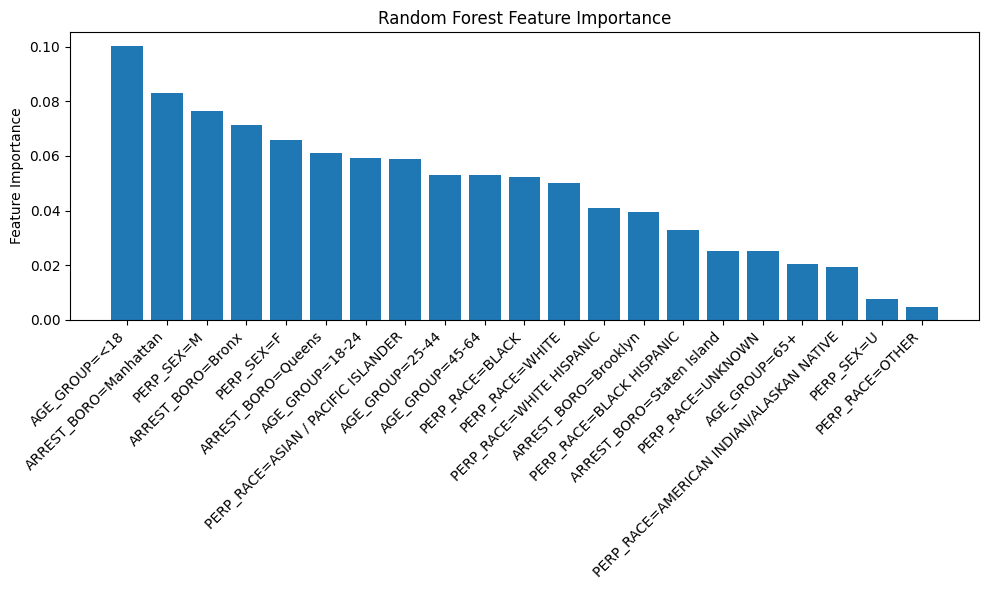

In [57]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import numpy as np

X = temp[['ARREST_BORO', 'PERP_SEX', 'PERP_RACE', 'AGE_GROUP']]
y = temp['OFNS_DESC']

def row_to_dict(X, y=None):
    return X.apply(dict, axis=1)

ft = FunctionTransformer(row_to_dict, validate=False)
dv = DictVectorizer(sparse=False)
rf = RandomForestClassifier(random_state=42)

model = make_pipeline(ft, dv, rf)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

feature_names = dv.feature_names_
importances = rf.feature_importances_

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Crime Variable Importance/Weight")

plt.bar(range(len(importances)), importances[indices], align="center")

plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha="right")
plt.ylabel("Feature Importance")

plt.tight_layout()
plt.show()
